## <font color="880000"> Everything You Know about Cross-Country Convergence Is (Now) Wrong </font>

In this [article](https://www.piie.com/blogs/realtime-economic-issues-watch/everything-you-know-about-cross-country-convergence-now-wrong), the authors provide interesting visualizations of the divergence between countries since the 1960s, to argue that while economists were busy refining the econometric tools for studying divergence, the basic facts about economic growth around the world turned completely upside down a quarter century ago—and the literature doesn’t seem to have noticed.     

The original [code](https://piie.com/system/files/documents/subramanian20181015data.zip) in stata can be found here. This is a python version of plotting the beta plot and the bubble plot.      

You can download the original data sets as suggested in the article, but here I have already cleared the data.    

Part of the beta code is attributed to [this open source code](https://github.com/psthomas/convergence/blob/255c7f043e6185af84df994aef28b0d82b512de5/convergence.ipynb). Here we use `matplotlib` to generate the plot instead of altair, since it is an easier visulization tool.  


In [32]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

import statsmodels.formula.api as smf
import statsmodels.api as sm

In [33]:
md_df=pd.read_csv('mad.csv')
md_df.rename({'mad':'gdp','mad_pop':'pop'}, axis=1, inplace=True)
md_df.head()

,ccode,country,year,gdp,pop
0,AFG,Afghanistan,1950,2392.0,8.150
1,AFG,Afghanistan,1951,2422.0,8.284
2,AFG,Afghanistan,1952,2462.0,8.425
3,AFG,Afghanistan,1953,2568.0,8.573
4,AFG,Afghanistan,1954,2576.0,8.728


In [34]:
pw_df=pd.read_csv('pwt.csv')
pw_df.rename({'pwt':'gdp','pwt_pop':'pop'}, axis=1, inplace=True)
pw_df.head()

,ccode,country,year,gdp,pop
0,ABW,Aruba,1970,5911.0,0.059065
1,ABW,Aruba,1971,6403.0,0.059438
2,ABW,Aruba,1972,6937.0,0.059849
3,ABW,Aruba,1973,7517.0,0.060239
4,ABW,Aruba,1974,8136.0,0.060525


In [35]:
wdi_df=pd.read_csv('wdi.csv')
wdi_df.rename({'wdi':'gdp','wdi_pop':'pop'}, axis=1, inplace=True)
wdi_df.head()

,country,ccode,year,gdpconstlcu,gdp,pop
0,Aruba,ABW,2011,NaN,35973.7810,0.102053
1,Aruba,ABW,2010,NaN,NaN,0.101669
2,Afghanistan,AFG,2017,14311.619,1803.9875,35.530081
3,Afghanistan,AFG,2016,14301.370,1802.6956,34.656032
4,Afghanistan,AFG,2015,14351.516,1809.0165,33.736494


In [36]:
def calculate_growth(year, endyear, df):
    '''Returns a dataframe with a log(start_gdp) column
    and a growth rate calculated by country between the specified
    year and the endyear.'''
    initial_df = df[(df['year'] == year)].copy()
    initial_df['start_gdp'] = initial_df['gdp']
    initial_df = initial_df[['ccode', 'start_gdp']]

    end_df = df[df['year'] == endyear].copy()
    end_df['end_gdp'] =  end_df['gdp']
    end_df = end_df[['ccode', 'end_gdp']]

    reg_df = initial_df.merge(end_df, on=['ccode'], how='inner')
    reg_df['growth_rate'] = (np.log(reg_df['end_gdp']/reg_df['start_gdp'])/(endyear-year))*100
    reg_df['log_start_gdp'] = np.log(reg_df['start_gdp'])
    
    return reg_df

def growth_betas(startyear, endyear, df):
    
    results = {}
    for year in range(startyear, endyear):
        reg_df = calculate_growth(year, endyear, df)
        # Using robust covariance type to match stata code.  
        poly_1 = smf.ols(formula='growth_rate ~ 1 + log_start_gdp', 
                         missing='drop', data=reg_df).fit(cov_type='HC3')
        beta = poly_1.params.log_start_gdp
        conf = poly_1.conf_int().loc['log_start_gdp']
        results[year] = [beta, conf[0], conf[1]]
    
    columns = ['beta', 'lower', 'upper']
    results_df = pd.DataFrame.from_dict(results, orient='index', columns=columns)
    results_df = results_df.reset_index()
    results_df.rename({'index':'year'}, axis="columns", inplace=True)
    return results_df

In [37]:
mdres_df = growth_betas(1950, 2016, md_df)
mdres_df['source'] = 'MAD'

In [38]:
pwres_df = growth_betas(1960, 2014, pw_df)
pwres_df['source'] = 'PWT'
pwres_df

,year,beta,lower,upper,source
0,1960,-0.045571,-0.384611,0.293470,PWT
1,1961,-0.037180,-0.368115,0.293755,PWT
2,1962,-0.100642,-0.445097,0.243813,PWT
3,1963,-0.084184,-0.408951,0.240584,PWT
4,1964,-0.082938,-0.421915,0.256038,PWT
5,1965,-0.095615,-0.450456,0.259227,PWT
6,1966,-0.076567,-0.425525,0.272391,PWT
7,1967,-0.066225,-0.422168,0.289719,PWT
8,1968,-0.049849,-0.401729,0.302030,PWT
9,1969,-0.065784,-0.420781,0.289213,PWT


In [39]:
wdires_df = growth_betas(1960, 2016, wdi_df)
wdires_df['source'] = 'WDI'
wdires_df

,year,beta,lower,upper,source
0,1960,0.003293,-0.354304,0.360890,WDI
1,1961,-0.043901,-0.435348,0.347547,WDI
2,1962,-0.047212,-0.459896,0.365473,WDI
3,1963,-0.046990,-0.445891,0.351911,WDI
4,1964,-0.060596,-0.439746,0.318555,WDI
5,1965,-0.061716,-0.427989,0.304557,WDI
6,1966,-0.057337,-0.412031,0.297357,WDI
7,1967,-0.073092,-0.433043,0.286859,WDI
8,1968,-0.104025,-0.458386,0.250335,WDI
9,1969,-0.110061,-0.448803,0.228680,WDI


In [40]:
df1=mdres_df[10:51]
x1=list(df1['year'])
y1=list(df1['beta'])
err1=list(df1['upper']-df1['beta'])

df2=pwres_df[0:41]
x2=list(df2['year'])
y2=list(df2['beta'])
err2=list(df2['upper']-df2['beta'])

df3=wdires_df[0:41]
x3=list(df3['year'])
y3=list(df3['beta'])
err3=list(df3['upper']-df3['beta'])

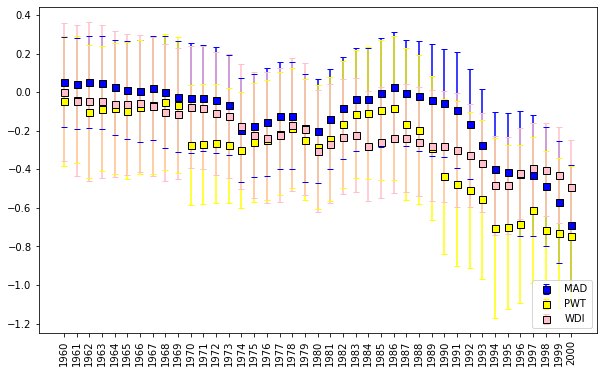

In [41]:
fig=plt.subplots(figsize=(10,6))
plt.errorbar(x=x1, y=y1, yerr=err1,ecolor='blue',capsize=3,
             linestyle="None", marker="s", markersize=7, mfc="blue", mec="black",label='MAD')

plt.errorbar(x=x2, y=y2, yerr=err2,ecolor='yellow',capsize=3,
             linestyle="None", marker="s", markersize=7, mfc="yellow", mec="black",label='PWT')

plt.errorbar(x=x3, y=y3, yerr=err3,ecolor='pink',capsize=3,
             linestyle="None", marker="s", markersize=7, mfc="pink", mec="black",label='WDI')

plt.xticks(x1, rotation=90)
plt.legend(loc='lower right')
plt.show()

To easily plot a beautiful bubble plot, we can use the package `ploty`.

In [42]:
pip install plotly

You are using pip version 9.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [43]:
import plotly.express as px

def growth(df,n):
    listx=[]
    listy=[]
    listz=[]
    listp=[]
    for i in set(df['ccode']):
        dfi=df[df['ccode']==i]
        g=((float(dfi[dfi['year']==2014]['gdp'])/float(dfi[dfi['year']==n]['gdp']))**(1/(2014-n)) - 1)*100
        gr=round(g,4)
        lgdp=np.log(float(dfi[dfi['year']==n]['gdp']))
        pop=float(dfi[dfi['year']==n]['pop'])
        listx.append(gr)
        listy.append(lgdp)
        listz.append(i)
        listp.append(pop)
      
    listgrowth={'growth rate':listx,'loggdp':listy,'ccode':listz,'pop':listp}
    dfgrowth=pd.DataFrame(listgrowth)
    fig = px.scatter(dfgrowth, x='loggdp', y='growth rate',  size="pop", color="ccode",
                 hover_name="ccode", log_x=False, size_max=60)
    fig.show()

growth(md_df,1960)    

In [44]:
growth(md_df,2000)

Then you can use this function to generate the plot of the growth rate from any year to present. The plot for 1960 and 2000 are presented in the original article. 